In [13]:
# creating dataframes
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df_invoice = pd.read_csv('fct_invoice.csv')
df_customer = pd.read_json('dim_customer.json')

Easy 1

In [12]:
# get the number of unique customer ids (customer-to-customer_id is one-to-one)
print(len(pd.unique(df_invoice['customer_id'])))

5191


Easy 2

In [3]:
# get the unique values of the category column
categories = pd.unique(df_invoice['category'])
print(categories)
print(len(categories))

['Clothing' 'Shoes' 'Books' 'Cosmetics' 'Food & Beverage' 'Toys'
 'Technology' 'Souvenir']
8


Easy 3

In [5]:
# make a frequency table (series) for each method
payment_method_value_count = df_invoice['payment_method'].value_counts()
# print the index (method) of the highest value (most often used)
print(payment_method_value_count.idxmax())
# print the actual value
print(payment_method_value_count[0])

Cash
44447


Medium 1

In [11]:
# make a new column in df_invoice called total_sales
df_invoice['sales'] = df_invoice['price'] * df_invoice['quantity']
# get the total sales for each category, then get the top 3
top_3_categories = df_invoice.groupby('category')['sales'].sum().nlargest(3)
# return the categories which are found in the indices
print(top_3_categories)

category
Clothing      1.139968e+08
Shoes         6.655345e+07
Technology    5.786235e+07
Name: sales, dtype: float64


Medium 2

In [7]:
# id in df_customer == customer_id in df_invoice
# get customer ids in df_invoice whose age in df_customer is over 45
ids_over_45 = df_customer[df_customer['age'] > 45]['id']
customers_over_45 = df_invoice[df_invoice['customer_id'].isin(ids_over_45)]

df_invoice['sales'] = df_invoice['price'] * df_invoice['quantity']
print(customers_over_45['sales'].sum())

82039768.15


Medium 3

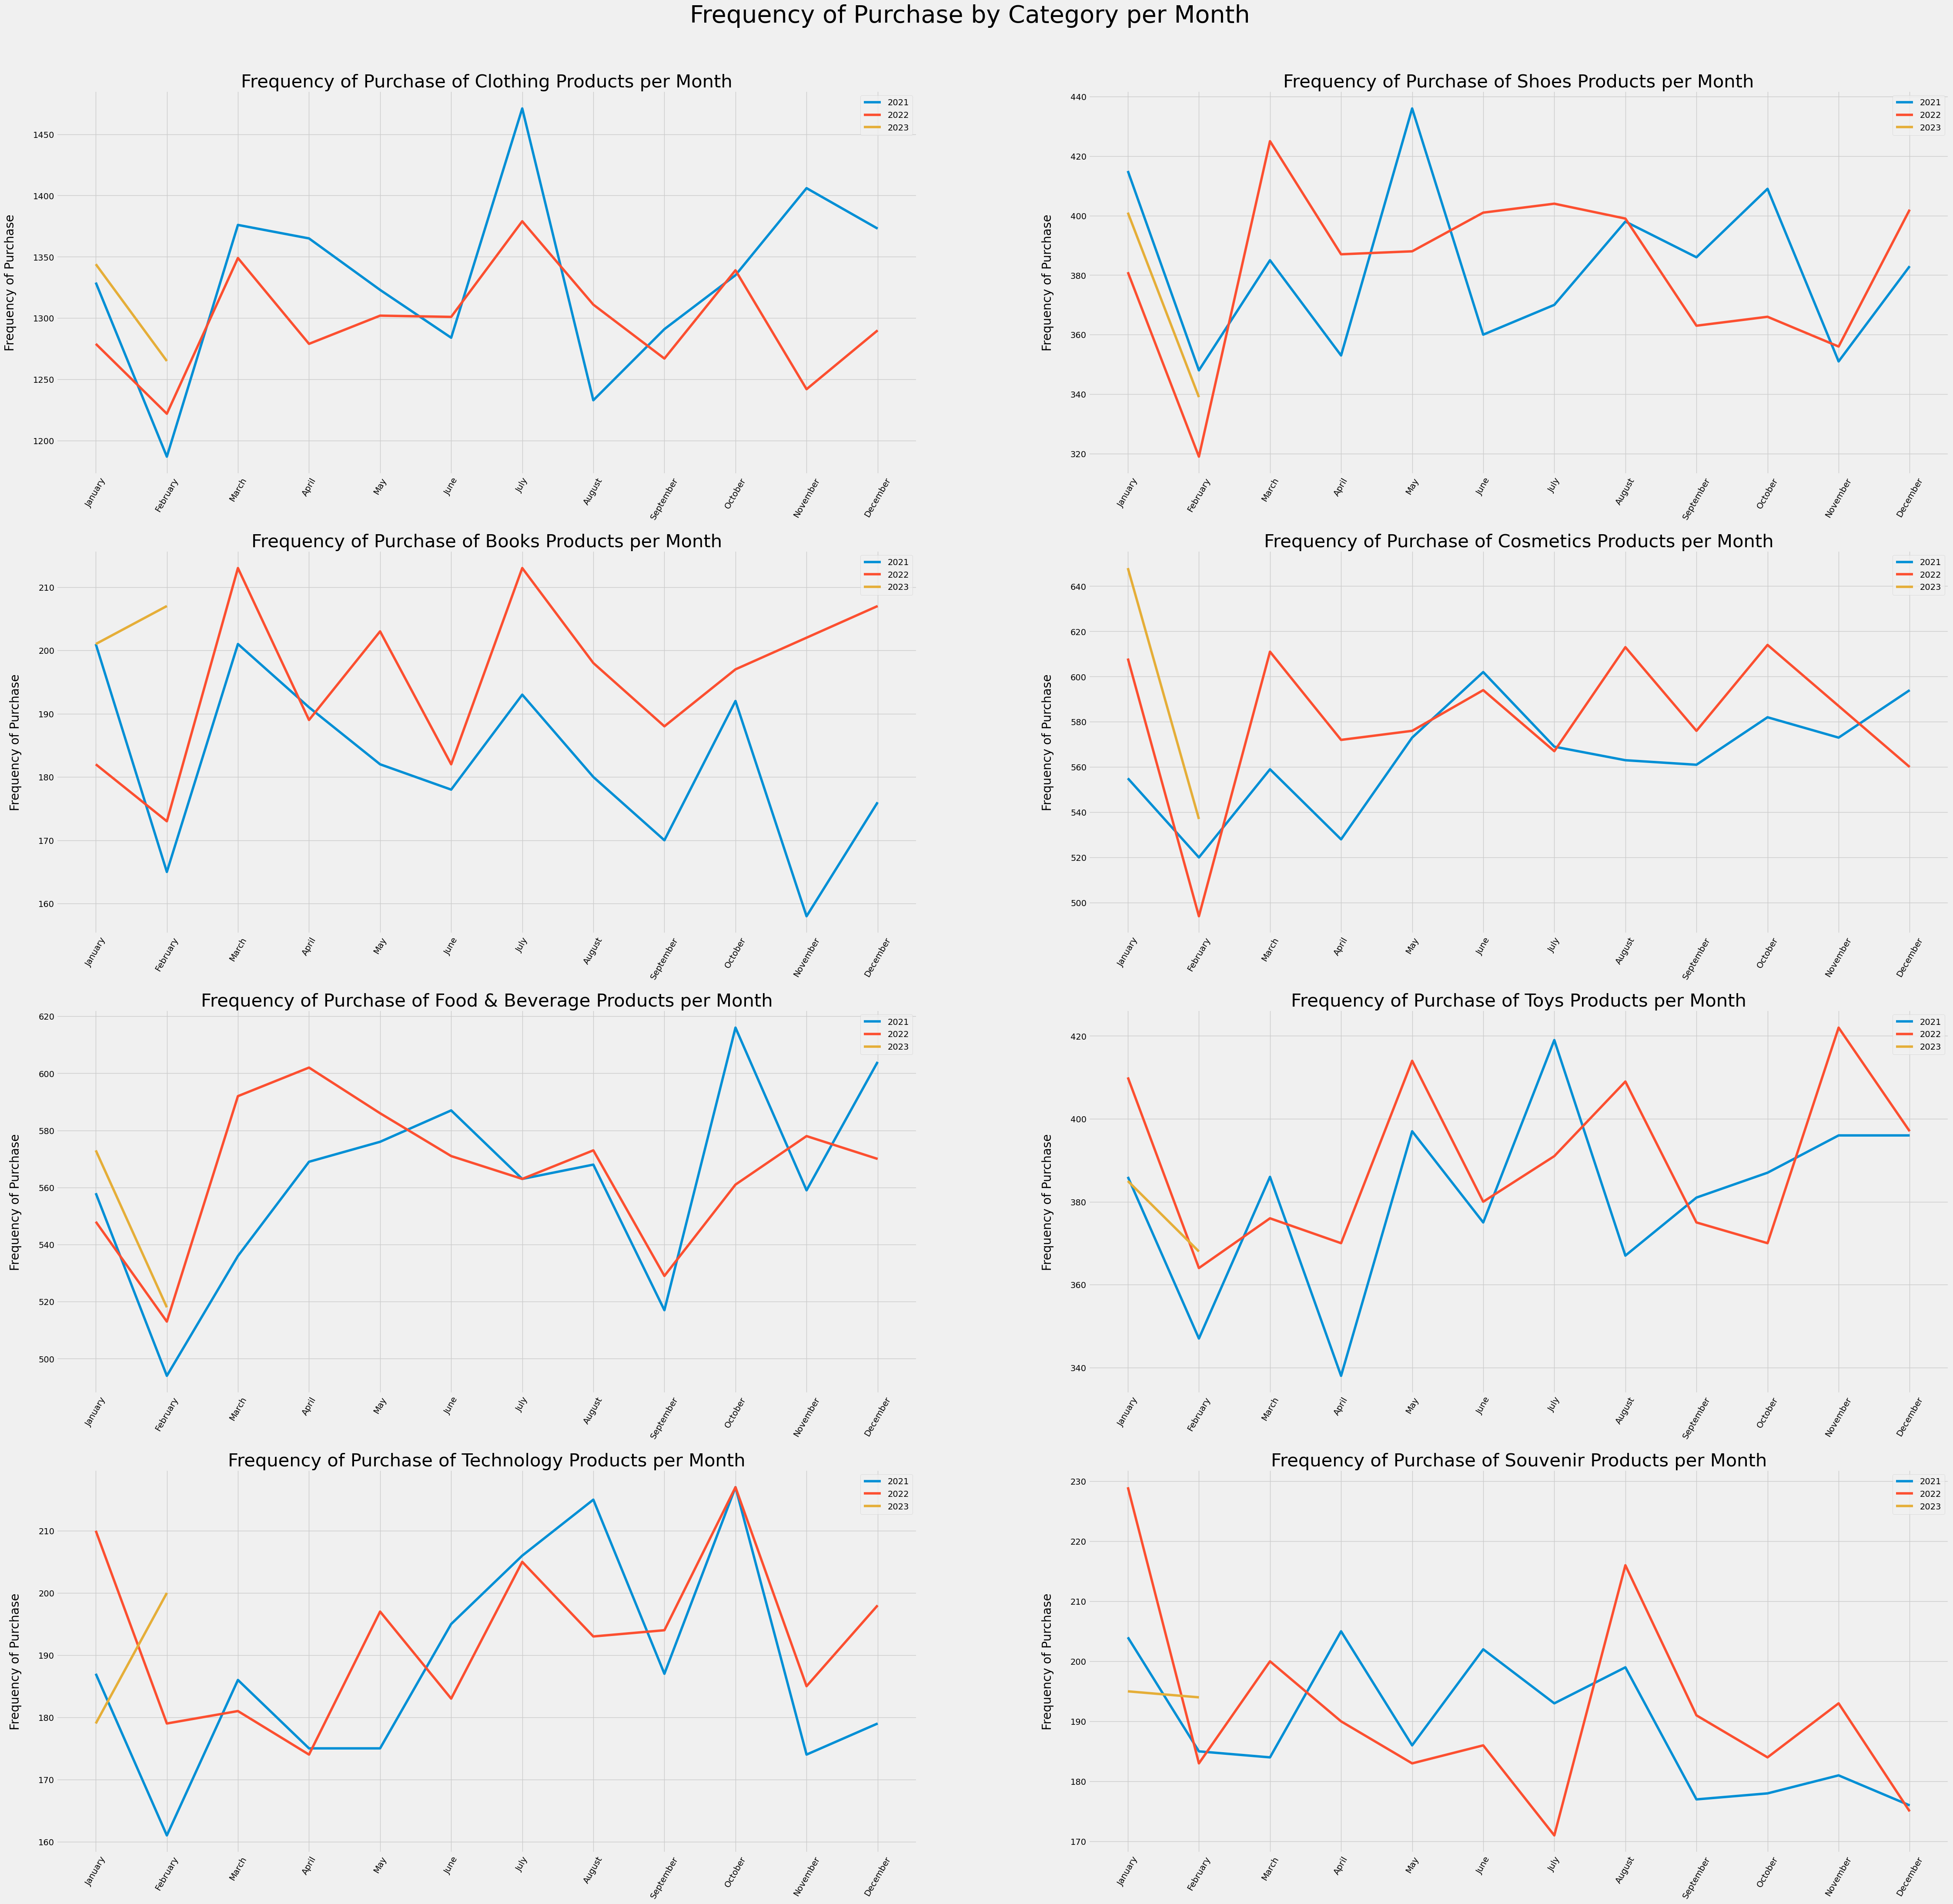

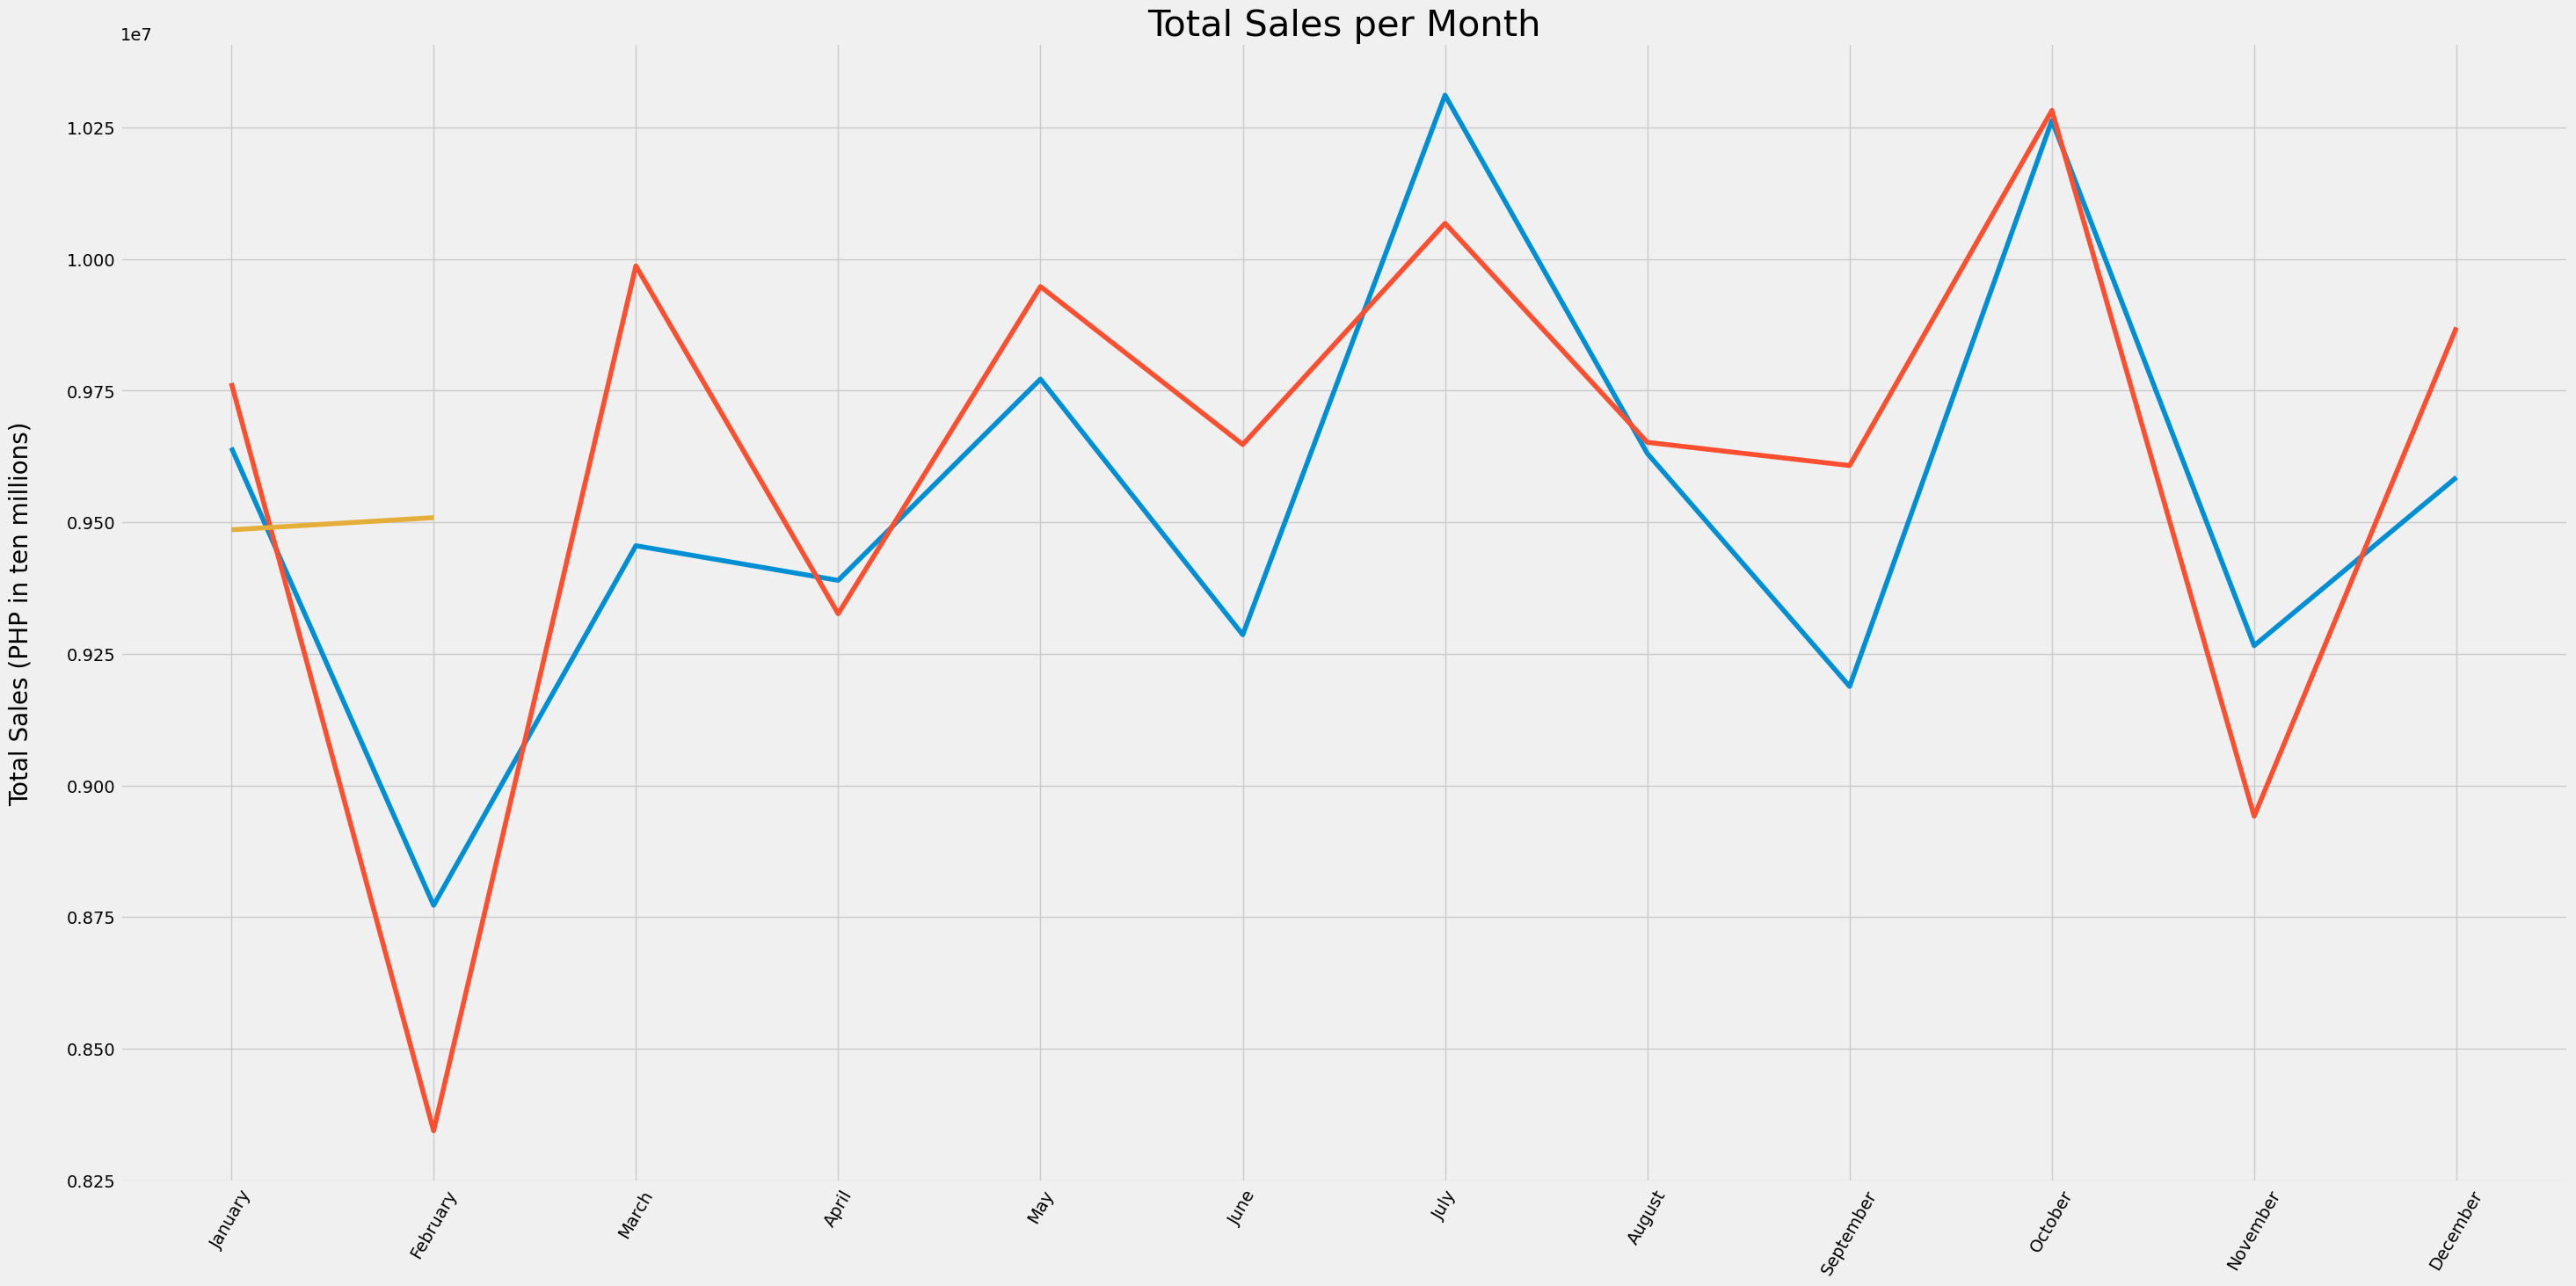

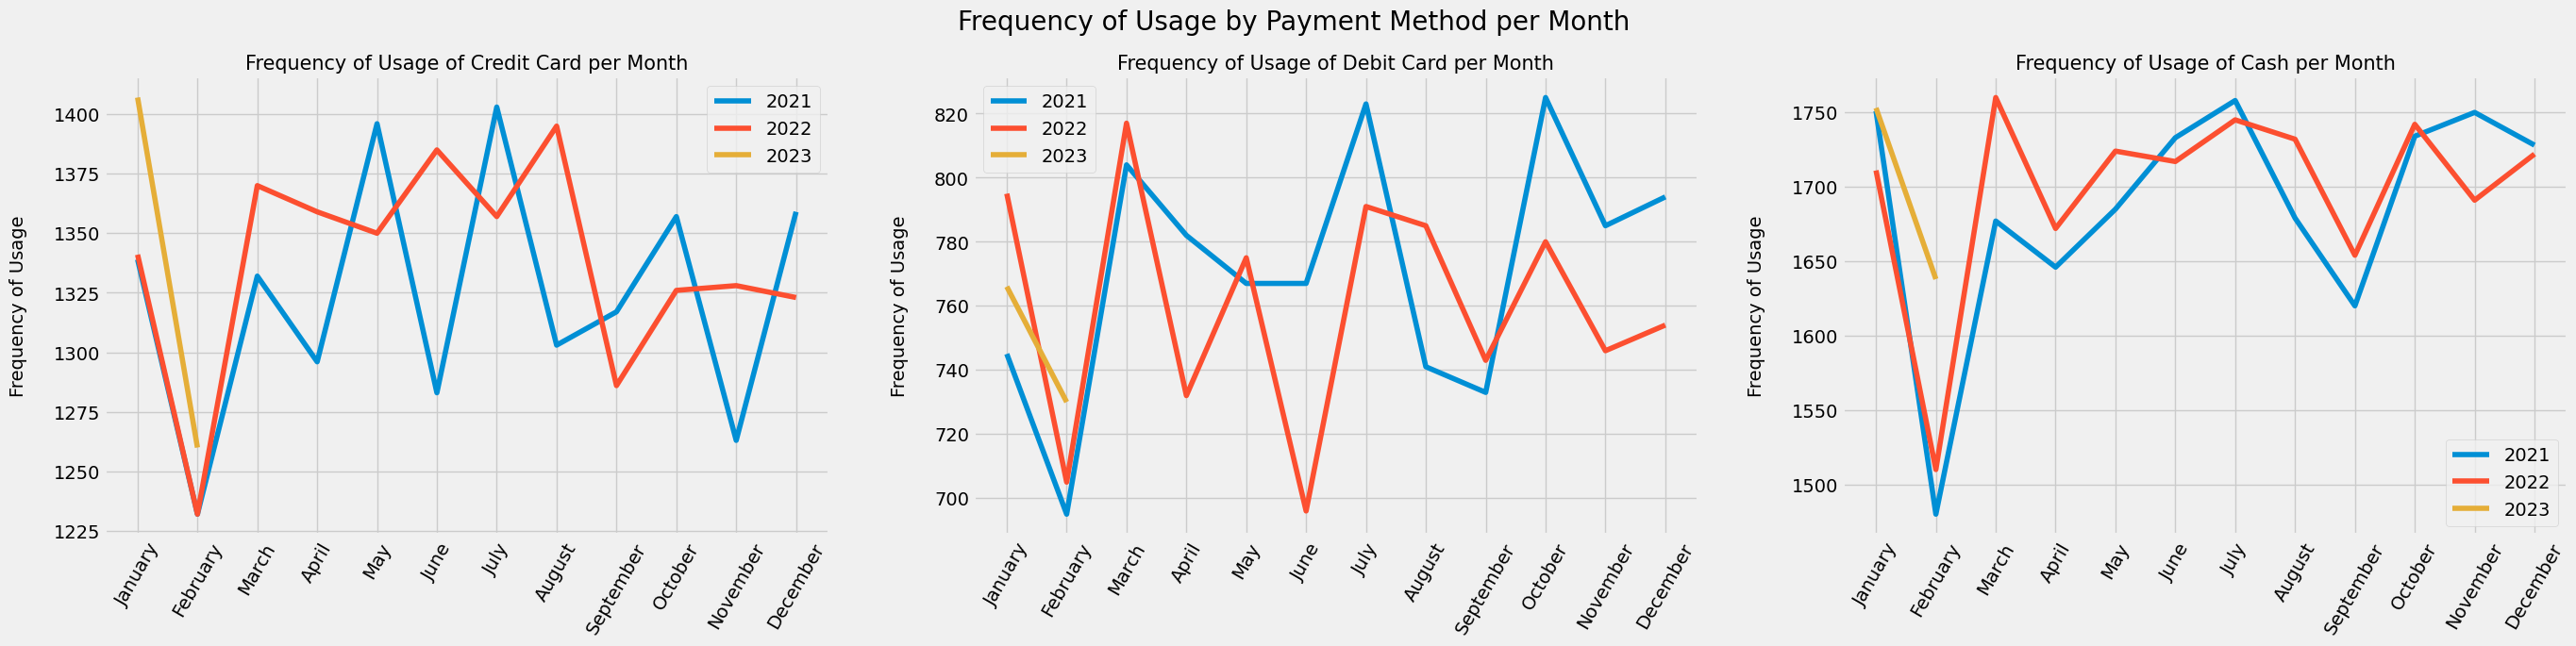

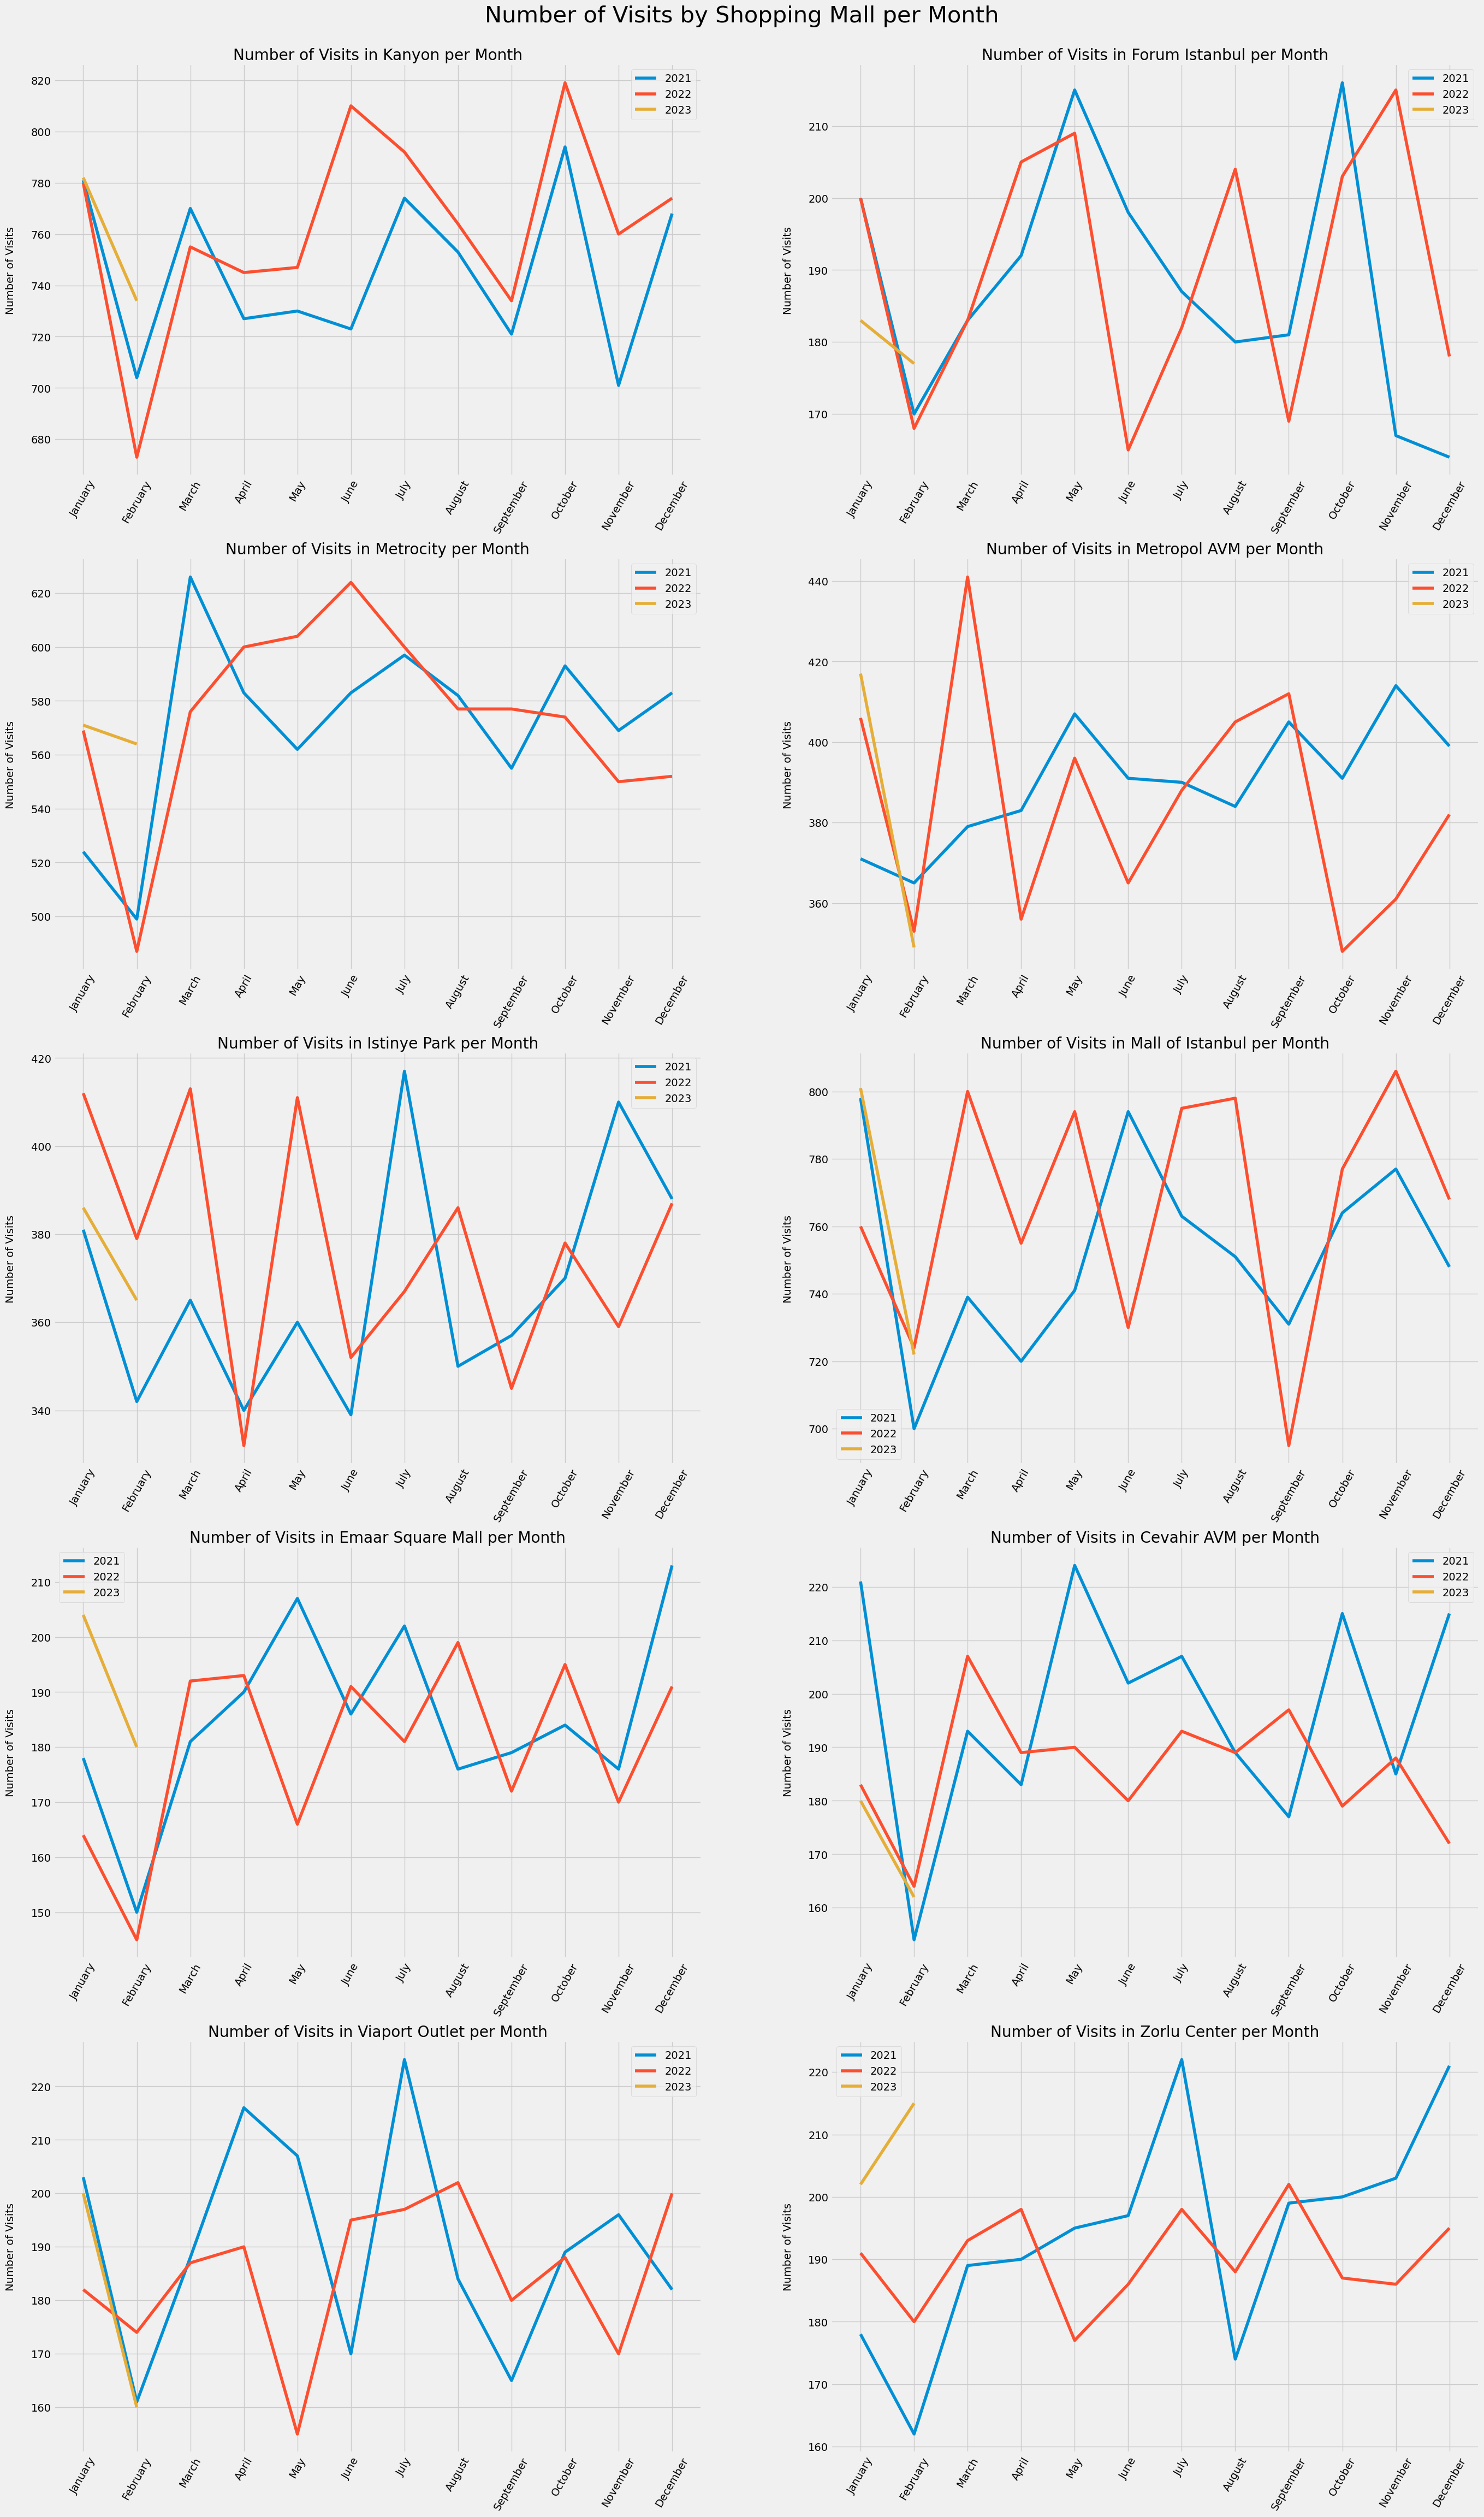

In [8]:
# category, sales (assume column is not made yet), payment method, shopping mall
df_invoice['sales'] = df_invoice['price'] * df_invoice['quantity']

# convert dates into datetime objects; after going through the data, I believe the dates are d/m/y
df_invoice['invoice_date'] = pd.to_datetime(df_invoice['invoice_date'], dayfirst=True)
# make a year-month column for dicts later
df_invoice['year_month'] = df_invoice['invoice_date'].dt.strftime('%Y-%m')

# prepare y-axis of each subplot; each point represents a month
# example: {first_category: {'2021': [Jan, ..., Dec],
#                            '2022': [Jan, ..., Dec],
#                            '2023': [Jan, Feb]},
#           ...,
#          {last_category:  {'2021': [Jan, ..., Dec],
#                            '2022': [Jan, ..., Dec],
#                            '2023': [Jan, Feb]}}

years = [str(i) for i in range(df_invoice['invoice_date'].dt.year.min(), df_invoice['invoice_date'].dt.year.max() + 1)]

# initialize dicts and other important stuff for later
categories_count = df_invoice.groupby(['year_month', 'category'])['category'].count()
sales_total = df_invoice.groupby(df_invoice['year_month'])['sales'].sum()
payment_methods_count = df_invoice.groupby(['year_month', 'payment_method'])['payment_method'].count()
malls_count = df_invoice.groupby(['year_month', 'shopping_mall'])['shopping_mall'].count()

categories_list = pd.unique(df_invoice['category'])
payment_methods_list = pd.unique(df_invoice['payment_method'])
malls_list = pd.unique(df_invoice['shopping_mall'])

categories_dict = {category: {year: [] for year in years} for category in categories_list}
sales_dict = {year: [] for year in years}
payment_methods_dict = {method: {year: [] for year in years} for method in payment_methods_list}
malls_dict = {mall: {year: [] for year in years} for mall in malls_list}

# update dicts with every purchase
for date in pd.unique(df_invoice['year_month'].sort_values()):
    if date == '2023-03':
        break

    for category in categories_list:
        categories_dict[category][date[:4]].append(categories_count.loc[(date, category)])

    sales_dict[date[:4]].append(sales_total.loc[(date)])
    
    for method in payment_methods_list:
        payment_methods_dict[method][date[:4]].append(payment_methods_count.loc[(date, method)])
      
    for mall in malls_list:
        malls_dict[mall][date[:4]].append(malls_count.loc[(date, mall)])

# create plots
plt.style.use('fivethirtyeight')

# x-axis
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# create subplots for categories
fig1, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(50, 50))
categories_subplots = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
fig1.suptitle('Frequency of Purchase by Category per Month', y=0.92, fontsize=40)

for i in range(len(categories_subplots)):
    for year in years:
        categories_subplots[i].plot(months[:len(categories_dict[categories_list[i]][year])], categories_dict[categories_list[i]][year], label=year) # [:len(code)] accounts for 2023 which only has 2 months
    plt.setp(categories_subplots[i].get_xticklabels(), rotation = 60)
    categories_subplots[i].legend()
    categories_subplots[i].set_title(f'Frequency of Purchase of {categories_list[i]} Products per Month', fontsize=30)
    categories_subplots[i].set_ylabel('Frequency of Purchase' + '\n', fontsize=20)
    
# create plot for sales
fig2, ax9 = plt.subplots(figsize=(32, 16))

for year in years:
    ax9.plot(months[:len(sales_dict[year])], sales_dict[year], label=year)
plt.setp(ax9.get_xticklabels(), rotation = 60)
ax9.set_title('Total Sales per Month', fontsize=30)
ax9.set_ylabel('Total Sales (PHP in ten millions)' + '\n', fontsize=20)

# create subplots for payment methods
fig3, (ax10, ax11, ax12) = plt.subplots(1, 3, figsize=(30, 6))
payment_methods_subplots = [ax10, ax11, ax12]
fig3.suptitle('Frequency of Usage by Payment Method per Month' + '\n', y=1, fontsize=20)

for i in range(len(payment_methods_subplots)):
    for year in years:
        payment_methods_subplots[i].plot(months[:len(payment_methods_dict[payment_methods_list[i]][year])], payment_methods_dict[payment_methods_list[i]][year], label=year)
    plt.setp(payment_methods_subplots[i].get_xticklabels(), rotation = 60)
    payment_methods_subplots[i].legend()
    payment_methods_subplots[i].set_title(f'Frequency of Usage of {payment_methods_list[i]} per Month', fontsize=15)
    payment_methods_subplots[i].set_ylabel('Frequency of Usage' + '\n')

# create subplots for malls
fig4, ((ax13, ax14), (ax15, ax16), (ax17, ax18), (ax19, ax20), (ax21, ax22)) = plt.subplots(5, 2, figsize=(30, 54))
malls_subplots = [ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21, ax22]
fig4.suptitle('Number of Visits by Shopping Mall per Month', y=0.9, fontsize=30)

for i in range(len(malls_subplots)):
    for year in years:
        malls_subplots[i].plot(months[:len(malls_dict[malls_list[i]][year])], malls_dict[malls_list[i]][year], label=year)
    plt.setp(malls_subplots[i].get_xticklabels(), rotation = 60)
    malls_subplots[i].legend()
    malls_subplots[i].set_title(f'Number of Visits in {malls_list[i]} per Month')
    malls_subplots[i].set_ylabel('Number of Visits' + '\n')

plt.show()

Seasonal Trends in Each Graph

Frequency of Purchase of Clothing Products per Month:
* Dip from January to February
* Rise from February to March
* General decrease from March to June
* Annual peak in July
* Dip from July to around August or September

Frequency of Purchase of Shoe Products per Month
* Dip from January to February
* Rise from February to March
* Low in November
* Rise from November to December
* Relatively equal levels on December and January

Frequency of Purchase of Book Products per Month
* Dip from January to February
* Annual peak in March
* General decrease from March to June
* Rise from June to July
* Decline from July to September

Frequency of Purchase of Cosmetics Products per Month
* Dip from January to February
* Rise from February to March
* Dip from March to April
* Rise from April to June
* Dip from June to July

Frequency of Purchase of Food & Beverage Products per Month
* Dip from January to February
* Rise from February to April
* Rise from July to August
* Dip from August to September
* Rise from September to November

Frequency of Purchase of Toy Products per Month
* Dip from January to February
* Rise from April to May
* Dip from May to June
* Rise from June to July or August
* Dip from July or August to August or September respectively
* Steady increase during -ber months; highest during November

Frequency of Purchase of Technology Products per Month
* Dip from January to February
* General rise from April to July
* Dip from around July or August to August or September respectively
* Rise from September to October
* Dip from October to November

Frequency of Purchase of Souvenir Products per Month
* Dip from January to February
* Rise from February to March or April
* Dip from August to September

———

Total Sales per Month
* Dips from January to February, May to June, July to September, and October to November
* Rise from February to March, April to May, June to July, September to October, and November to December
* Lowest on February
* Highest on July and October

———

Frequency of Usage of Credit Card per Month
* Dip from January to February
* Rise from February to March
* Can expect rise in between May and July
* Dip from July or August to August or September respectively

Frequency of Usage of Debit Card per Month
* Dip from January to February
* Rise from February to March
* Rise from June to July
* Decline from July to September
* Rise from September to October
* Dip from October to November
* Rise from from November to December

Frequency of Usage of Cash per Month
* Dip from January to February (annual bottom)
* Rise from February to March
* Increase from April to July
* Decline from July to September
* Rise from September to October

———

Number of Visits in Kanyon per Month
* Dip from January to February
* Rise from February to March
* Rise from May or June to June or July respectively
* Decrease from June or July to September
* Rise from September to October
* Dip from October to November
* Rise from November to December
* Relatively equal levels for December and January

Number of Visits in Forum Istanbul per Month
* Dip from January to February
* Rise from February to May
* Rise from September to October
* Decrease from November to December

Number of Visits in Metrocity per Month
* Dip from January to February
* Rise from February to March
* General decrease from June or July to August or September respectively
* Relatively stable in the second semester

Number of Visits in Metropol AVM per Month
* Dip from January to February
* Local maximum in May
* Dip in October
* Rise in November

Number of Visits in Istinye Park per Month
* Dip, rise, dip, rise, dip, rise from January to July
* General increase in -ber months

Number of Visits in Mall of Istanbul per Month
* Dip, rise, dip from January to April
* Dip in September
* Rise from September to November
* Decrease from November to December

Number of Visits in Emaar Square Mall per Month
* Dip from January to February
* Rise from February to April
* Relatively equal levels of fluctuation from July to September

Number of Visits in Cevahir AVM per Month
* Dip, rise, dip from January to April

Number of Visits in Viaport Outlet per Month
* Dip from January to February
* Rise from February to April
* Dip from April to May or June
* Dip, rise from August to October

Number of Visits in Zorlu Center per Month
* Dip from January to February
* Rise from February to April
* Rise from May to July
* Dip, rise from July to September
* Rise from November to December

Hard

In [9]:
# create sales column
df_invoice['sales'] = df_invoice['quantity'] * df_invoice['price']

# create age range column
def age_range(age):
    if np.isnan(age):
        return np.nan
    return f'{int(age // 10 * 10)}-{int(age // 10 * 10 + 9)}'

df_customer_new_index = df_customer.set_index('id')
ages = pd.Series(list(df_customer_new_index.loc[df_invoice['customer_id'], 'age']))
df_invoice['age_range'] = ages.apply(age_range)

# create pivot table (does not include people whose age is a nan value)
display(pd.pivot_table(df_invoice, index='category', columns='age_range', values='sales', aggfunc='sum'))

age_range             10-19        20-29        30-39        40-49  \
category                                                             
Books              12801.75     79461.75     84143.10     87203.40   
Clothing         1927413.84  10250732.80  11354126.96  11215189.92   
Cosmetics         109619.36    605915.32    723544.70    665034.96   
Food & Beverage    13582.31     73491.96     87246.86     89553.29   
Shoes             993281.35   5924878.24   7200839.66   7025590.02   
Souvenir           12375.15     54943.32     64092.72     66391.80   
Technology       1129800.00   5261550.00   6159300.00   5954550.00   
Toys               60426.24    385100.80    420582.40    390906.88   

age_range              50-59        60-69       70-79       80-89  
category                                                           
Books               74962.20     80476.80    54827.85    26664.00  
Clothing         10321851.76  10660642.08  7769371.28  4493698.00  
Cosmetics          587780.96    649990.76   419082.62   254531.60  
Food & Beverage     72425.04     80976.09    55050.98    31332.93  
Shoes             5852857.84   5978893.54  4480269.05  2628744.60  
Souvenir            54943.32     55025.43    38673.81    23718.06  
Technology        4435200.00   5471550.00  3638250.00  1946700.00  
Toys               345067.52    363955.20   273244.16   153932.80